# Weinberg experiments

In [1]:
# Importing all packages
# normalizing flows packages
import torch
from torch.distributions.beta import Beta

# loforest and locart functions
from CP2LFI.loforest import ConformalLoforest, tune_loforest_LFI
from CP2LFI.scores import Scores, LambdaScore, WaldoScore, BFFScore, E_valueScore
from CP2LFI.posterior_models import normflow_posterior
from clover import LocartSplit

# quantile regression
from sklearn.ensemble import HistGradientBoostingRegressor

# plotting and numpy
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import itertools
import pandas as pd

# utils functions
from CP2LFI.utils import obtain_quantiles, fit_post_model

# package to simulate from tractable
from hypothesis.benchmark import weinberg

Function to compute MAE for fixed $n$ and $B$:

In [2]:
# function to compute MAE for a single N and B
def compute_MAE_N_B(
    kind,
    score,
    theta_grid_eval,
    simulator,
    prior,
    N = 5,
    B = 10000,
    alpha=0.05,
    min_samples_leaf = 300,
    n_estimators = 200,
    K = 50,
    B_valid= 500,
    N_lambda = 250,
    K_grid= np.concatenate((np.array([0]), np.arange(15, 95, 5))),
    naive_n=500,
    disable_tqdm = True,
    seed = 45,
    n_lambda = 300,
    log_transf = False,
    split_calib = False,
    using_beta = False,
):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    quantiles_dict = obtain_quantiles(
    kind = kind, 
    score = score, 
    theta_grid_eval = theta_grid_eval, 
    simulator = simulator,
    prior = prior, 
    N = N, 
    B = B, 
    alpha = alpha, 
    min_samples_leaf = min_samples_leaf, 
    n_estimators = n_estimators, 
    K = K,
    disable_tqdm = disable_tqdm,
    B_valid = B_valid,
    N_lambda= N_lambda,
    K_grid = K_grid,
    naive_n = naive_n,
    log_transf = log_transf,
    split_calib = split_calib,
    using_beta = using_beta,
)
    mae_list, se_list, methods_list, N_list, B_list = [], [], [], [], []
    err_data = np.zeros((theta_grid_eval.shape[0], 5))
    l = 0
    for theta in tqdm(theta_grid_eval, desc = "Evaluating coverage in this setting"):
        if theta_grid_eval.ndim == 1:
            theta_repeated = torch.tensor([theta]).reshape(1, -1).repeat_interleave(repeats = n_lambda*N, dim = 0)
        else:
            theta_repeated = torch.tensor([theta]).repeat_interleave(repeats = n_lambda*N, dim = 0)
            
        # simulating lambdas for testing
        X_net = simulator(theta_repeated)
        if log_transf:
            X_net = torch.log(X_net)
        X_dim = X_net.shape[1]
        X_net = X_net.reshape(n_lambda, N * X_dim)

        stat = score.compute(theta_repeated.numpy()[0:n_lambda, :], X_net.numpy(), disable_tqdm = True)
                
        # comparing coverage of methods
        locart_cover = np.mean(stat <= quantiles_dict["locart"][l])
        loforest_cover = np.mean(stat <= quantiles_dict["loforest_fixed"][l])
        loforest_tuned_cover = np.mean(stat <= quantiles_dict["loforest_tuned"][l])
        boosting_cover = np.mean(stat <= quantiles_dict["boosting"][l])
        naive_cover = np.mean(stat <= quantiles_dict["naive"][l])

        # appending the errors
        err_locart = np.abs(locart_cover - (1 - alpha))
        err_loforest = np.abs(loforest_cover - (1 - alpha))
        err_loforest_tuned = np.abs(loforest_tuned_cover - (1 - alpha))
        err_boosting = np.abs(boosting_cover - (1 - alpha))
        err_naive = np.abs(naive_cover - (1 - alpha))
        
            # saving in numpy array
        err_data[l, :] = np.array([err_locart, err_loforest, err_loforest_tuned, err_boosting, err_naive])
        l += 1

    mae_list.extend(np.mean(err_data, axis=0).tolist())
    se_list.extend((np.std(err_data, axis=0) / np.sqrt(theta_grid_eval.shape[0])).tolist())
    methods_list.extend(["LOCART", "LOFOREST", "tuned LOFOREST", "boosting", "monte-carlo"])
    N_list.extend([N] * 5)
    B_list.extend([B] * 5)

    stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    return stats_data

Fixing simulator and grid of evaluation:

In [14]:
simulator = weinberg.Simulator(default_beam_energy=40.0)
prior = weinberg.Prior()

# weinberg grid
n_out = 300
thetas_valid = np.linspace(0.501, 1.499, n_out)

Fitting posterior model for $n = 5$:

Fitting normalizing flows posterior estimator:  10%|▉         | 191/2000 [02:19<22:05,  1.36it/s]

Early stopping at epoch 191
a


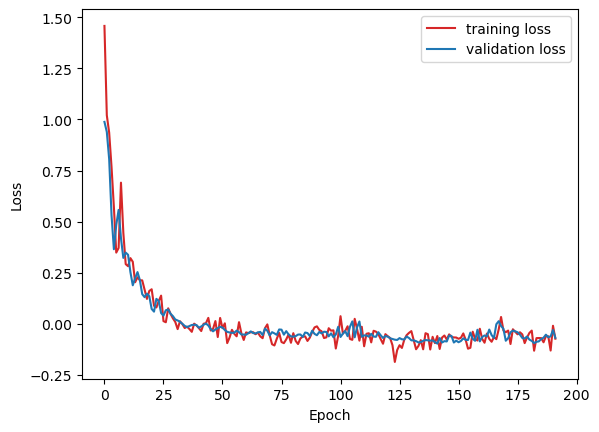

In [4]:
nflow_post = fit_post_model(simulator = simulator, prior = prior, B_model = 20000, n = 5, seed = 45, split_seed = 0)

defining scores:

In [5]:
# defining scores
# waldo score
waldo_score = WaldoScore(nflow_post, is_fitted = True)
waldo_score.fit()

# BFF score
bff_score = BFFScore(nflow_post, is_fitted = True)
bff_score.fit()

# e-value score
e_value_score = E_valueScore(nflow_post, is_fitted = True)
e_value_score.fit()

## Comparing all models for $n = 5$:

Considering a beta(1/2, 1/2) prior for calibration:

In [15]:
bff_stats_weinberg_beta = compute_MAE_N_B(
    kind = "weinberg", 
    score = bff_score, 
    theta_grid_eval = thetas_valid, 
    simulator = simulator, 
    prior = prior, 
    N = 5, 
    B = 10000, 
    B_valid = 1000, 
    N_lambda = 500,
    seed = 125,
    K = 70,
    n_estimators = 200,
    min_samples_leaf = 300,
    log_transf = False,
    split_calib = False,
    using_beta = True,
    )

Running naive method


fitting monte carlo cutoffs: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


[-0.5328459 -1.7756813 -1.3413088 ... -1.4556727 -1.4099677 -2.1396556]
Running all the other methods
Obtaining tuning sample


Simulating all tuning sample: 100%|██████████| 1000/1000 [07:14<00:00,  2.30it/s]


Fitting tuned loforest


Evaluating coverage in this setting: 100%|██████████| 300/300 [01:19<00:00,  3.76it/s]


In [16]:
bff_stats_weinberg_beta

,methods,N,B,MAE,se
0,LOCART,5,10000,0.018544,0.000845
1,LOFOREST,5,10000,0.015311,0.000721
2,tuned LOFOREST,5,10000,0.015222,0.000731
3,boosting,5,10000,0.015256,0.000685
4,monte-carlo,5,10000,0.015456,0.000747


In [17]:
waldo_stats_weinberg_beta = compute_MAE_N_B(
    kind = "weinberg", 
    score = waldo_score, 
    theta_grid_eval = thetas_valid, 
    simulator = simulator, 
    prior = prior, 
    N = 5, 
    B = 10000, 
    B_valid = 350, 
    N_lambda = 150,
    seed = 125,
    K = 70,
    n_estimators = 200,
    min_samples_leaf = 300,
    log_transf = False,
    split_calib = False,
    using_beta = True,
    )

Running naive method


fitting monte carlo cutoffs: 100%|██████████| 20/20 [09:12<00:00, 27.64s/it]


[0.33889982 0.61996692 0.846829   ... 0.45980597 1.3070426  0.43137616]
Running all the other methods
Obtaining tuning sample


Simulating all tuning sample: 100%|██████████| 350/350 [57:46<00:00,  9.90s/it]


Fitting tuned loforest


Evaluating coverage in this setting: 100%|██████████| 300/300 [1:41:47<00:00, 20.36s/it]


In [18]:
waldo_stats_weinberg_beta

,methods,N,B,MAE,se
0,LOCART,5,10000,0.016878,0.000803
1,LOFOREST,5,10000,0.014533,0.000645
2,tuned LOFOREST,5,10000,0.014200,0.000588
3,boosting,5,10000,0.016767,0.000751
4,monte-carlo,5,10000,0.017167,0.000806


In [19]:
e_value_stats_weinberg_beta = compute_MAE_N_B(
    kind = "weinberg", 
    score = e_value_score, 
    theta_grid_eval = thetas_valid, 
    simulator = simulator, 
    prior = prior, 
    N = 5, 
    B = 10000, 
    B_valid = 350, 
    N_lambda = 150,
    seed = 125,
    K = 70,
    n_estimators = 250,
    min_samples_leaf = 300,
    log_transf = False,
    split_calib = False,
    using_beta = True,
    )

Running naive method


fitting monte carlo cutoffs: 100%|██████████| 20/20 [40:11<00:00, 120.57s/it]


[0.767 0.765 0.146 ... 0.331 0.906 0.289]
Running all the other methods
Obtaining tuning sample


Simulating all tuning sample: 100%|██████████| 350/350 [2:58:16<00:00, 30.56s/it]  


Fitting tuned loforest


Evaluating coverage in this setting: 100%|██████████| 300/300 [4:24:37<00:00, 52.93s/it]  


In [20]:
e_value_stats_weinberg_beta

,methods,N,B,MAE,se
0,LOCART,5,10000,0.019778,0.000910
1,LOFOREST,5,10000,0.020433,0.000960
2,tuned LOFOREST,5,10000,0.020556,0.000947
3,boosting,5,10000,0.015056,0.000641
4,monte-carlo,5,10000,0.023878,0.001626
